Strat 2: Pretraining BERT on large corpus of text (MLM objective)

In [1]:
!pip install datasets
!pip install evaluate


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
)

import numpy as np
import tensorflow as tf
import torch
from datasets import Dataset, load_dataset, DatasetDict


import pandas as pd


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
"""Constants"""

# The dataset taken from https://huggingface.co/ESGBERT
dataset_url = "hf://datasets/ESGBERT/environmental_2k/environmental_2k.csv"
big_dataset_url = "hf://datasets/ESGBERT/environment_data/environment_data.csv"

# The pretrained model checkpoint being used (2 layer, 512 hidden dimension, 8 attention heads)
model_checkpoint = "google/bert_uncased_L-2_H-512_A-8"

"""
Other models to try:
distilbert-base-uncased
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)



using device:  cpu


In [4]:
# Initialize tokenizer and model from the same model_checkpoint (so they're compatible)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
mlm_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
tokenizer

BertTokenizerFast(name_or_path='google/bert_uncased_L-2_H-512_A-8', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
"""sample model pipeline"""
sample = "test [MASK] some [MASK]thin [MASK]"

# Tokenize text
sample_tokenized = tokenizer([sample], return_tensors='pt', padding=True)

# run through model (tokenizer output is a dictionary with all input arguments for the model)
samp_out = mlm_model(**sample_tokenized)

print("output logits: ", samp_out.logits)

output logits:  tensor([[[ -9.4125,  -8.4637,  -9.1380,  ...,  -8.2152, -11.9307,  -7.7812],
         [ -9.7084,  -8.3756,  -8.8134,  ...,  -7.9416, -10.9808,  -8.9557],
         [ -8.2224,  -8.2958,  -7.6333,  ...,  -7.0930, -10.0589,  -4.0423],
         ...,
         [-10.0483, -10.6377,  -9.6757,  ...,  -8.6886, -10.9759,  -9.4402],
         [ -7.4171,  -9.1206,  -7.7921,  ...,  -8.2052,  -8.1394,  -6.1813],
         [ -8.9019,  -8.2693,  -7.9525,  ...,  -7.9172, -11.5575,  -7.4230]]],
       grad_fn=<ViewBackward0>)


In [ ]:
"""Testing the model on it's masked language modelling objective"""

text = "This is a great [MASK]."

# Tokenize text and send through model
inputs = tokenizer(text, return_tensors="pt")
token_logits = mlm_model(**inputs).logits

# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[1, 0]
mask_token_logits = token_logits[0, mask_token_index, :]

# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.argsort(mask_token_logits, descending=True)[:5].tolist()

# Output sentence with replaced mask for each of the top-5
for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

>>> This is a great event.
>>> This is a great place.
>>> This is a great idea.
>>> This is a great thing.
>>> This is a great deal.


# Preparing Data
Loading, splitting, tokenizing and chunking the data into batches for training

In [6]:
"""Read environment dataset from ESGBERT (big and 2k labelled samples) from huggingface"""
# Change from 'env' to different column name if using a differentn dataset from https://huggingface.co/ESGBERT (eg. 'soc' for society)
df = pd.read_csv(dataset_url)[['text', 'env']]
df['env'] = df['env'].astype('int16')

df_big = pd.read_csv(big_dataset_url)

In [7]:
df, df_big

(                                                   text  env
 0     The balance included in-kind donations prepare...    0
 1     Internal controls and risk management The Boar...    0
 2     This analysis does not take into account the e...    1
 3     Change in Chief Financial Officer and plc Boar...    0
 4     Consideration and prioritisation of climate ri...    1
 ...                                                 ...  ...
 1995  The types of change are similar under the two ...    1
 1996  • The effects of weather and natural disasters...    1
 1997  In future years, water consumption per employe...    1
 1998  z Scope 1, Scope 2, and, if appropriate, Scope...    1
 1999  To help contribute to our carbon neutrality go...    1
 
 [2000 rows x 2 columns],
                                                   sentence
 0        Over the course of the year, your partnership ...
 1        Working with community and Indigenous-led coal...
 2        And together we made a more inclusive 

In [11]:
train_size = 10_000 # select train_size based on resources; or just leave as ratio (eg. 0.8) to use entire dataset
test_size = int(0.1 * train_size)

ds = Dataset.from_pandas(df)
dataset = ds.train_test_split(train_size=0.8)

ds_big = Dataset.from_pandas(df_big)
dataset_big = ds_big.train_test_split(train_size=train_size, test_size=test_size)
dataset_big = dataset_big.rename_columns({'sentence': 'text'})


In [12]:
"""View samples (input-label pairs) of data"""
samp = dataset['train'].shuffle().select(range(5))
for row in samp:
    print(f"text: {row['text']}, \nlabel: {row['env']}")

text: Of the 191 Directors and employees at period end: one of 11 Directors; seven of 27 senior managers; and 49 of 180 staff were females., 
label: 0
text: For the year ended 31 December 2010, we paid out €8.4m in the form of dividends to our shareholders.  , 
label: 0
text: The Group is committed to managing its business and operations responsibly and to protecting the environment.  , 
label: 1
text: This was partially offset by increased sales in our Building Products Division driven by a strong residential sector in the United States (US), particularly in Repair, Maintenance and Improvement (RMI) activity., 
label: 0
text: We have a strategic cooperation relationship with major partners for realizing a closed-loop., 
label: 0


In [13]:
"""View samples of large sentence corpus"""
samp_big = dataset_big['train'].shuffle().select(range(5))
for row in samp:
    print(f"text: {row['text']}")

text: Of the 191 Directors and employees at period end: one of 11 Directors; seven of 27 senior managers; and 49 of 180 staff were females.
text: For the year ended 31 December 2010, we paid out €8.4m in the form of dividends to our shareholders.  
text: The Group is committed to managing its business and operations responsibly and to protecting the environment.  
text: This was partially offset by increased sales in our Building Products Division driven by a strong residential sector in the United States (US), particularly in Repair, Maintenance and Improvement (RMI) activity.
text: We have a strategic cooperation relationship with major partners for realizing a closed-loop.


In [14]:
"""Input Preprocessing"""

# Tokenizing function
def tokenize_function(examples, text_field="text"):
    result = tokenizer(examples[text_field])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Process labels to make them multi-class (2 classes) for use of cross-entropy loss
def tupelize_labels(examples):
    result = examples
    result['label'] = [[val, 1-val] for val in examples['env']]
    return result

# Map transformations over datasets. Use batched=True to activate multithreading

# Prepare dataset for mlm pretraining--this only requires tokenized input text and the masked input ids and locations for labels
tokenized_datadict_for_mlm = dataset_big.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

tokenized_dataset_classification = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

tokenized_dataset_classification = tokenized_dataset_classification.map(
    tupelize_labels, batched=True
)

tokenized_datadict_for_mlm

Map: 100%|██████████| 400/400 [00:00<00:00, 95081.98 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 1000
    })
})

In [15]:
"""View train dataset"""
pd.DataFrame(tokenized_datadict_for_mlm['train']).head()

,input_ids,token_type_ids,attention_mask,word_ids
0,"[101, 2005, 2742, 1010, 4031, 2640, 1998, 2458...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 1..."
1,"[101, 2023, 2097, 2156, 2149, 3189, 2025, 2069...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
2,"[101, 1008, 3602, 1024, 20563, 3508, 6017, 210...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 8, 8, 9, ..."
3,"[101, 2057, 2031, 2036, 2794, 1037, 2047, 3277...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
4,"[101, 6089, 2005, 3224, 3688, 3073, 2019, 2043...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."


<Axes: >

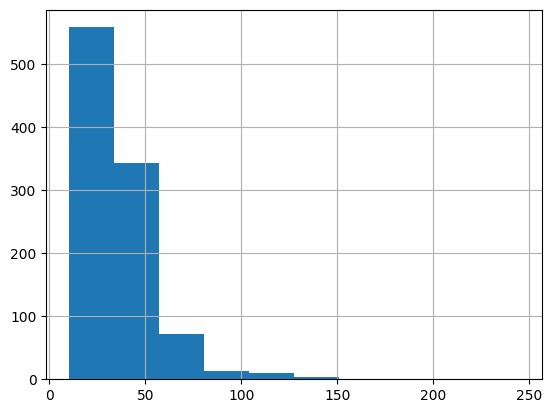

In [16]:
"""Analyse distribution of token lengths for setences in the dataset"""
tst = pd.DataFrame(tokenized_datadict_for_mlm['test'])['input_ids'].apply(len)
tst.hist()

In [17]:
"""Further data processing: group setnences into one long setnence and split into chunk-sized sentences"""
def get_stacked_dataset(dataset:Dataset, chunk_size=256):
    # Convert to dictionary
    dataset_dict = dataset.to_dict() if isinstance(dataset, Dataset) else dataset
    stacked_len = len(np.hstack(dataset_dict[list(dataset_dict.keys())[0]]))

    # First group all texts into one long text (np.hstack) before splitting into even sized chunks (np.hsplit)
    dataset_dict = {
        k:np.hsplit(np.hstack(dataset_dict[k])[:-(stacked_len%chunk_size)], stacked_len//chunk_size) for k in dataset_dict
    }
    # Create a column called labels -- this is for mlm objective, so it's the same as the input_ids
    dataset_dict['labels'] = dataset_dict['input_ids'].copy()

    # If fcn was called with a Dataset, return a Dataset; else return dict
    return Dataset.from_dict(dataset_dict) if isinstance(dataset, Dataset) else dataset_dict

# Test: Perform chunking, verify length of a chunk is what you set it to
test = get_stacked_dataset(dataset=tokenized_datadict_for_mlm['test'], chunk_size=256)
len(test[-1]['input_ids'])


256

In [18]:
"""Final dataset that we will be using to train and evaluate our model"""
tokenized_chunked_datadict = tokenized_datadict_for_mlm.map(get_stacked_dataset, batched=True)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 8412.77 examples/s]


In [19]:
"""Brief check of a sample's token length"""
print("token-length of a sentence: ", len(tokenized_chunked_datadict["train"][0]["input_ids"]))

token-length of a sentence:  256


In [21]:
from transformers import DataCollatorForLanguageModeling, DataCollatorForWholeWordMask, DefaultDataCollator, DataCollatorWithPadding#DataCollatorForSe

"""
Data collation--default functions that prepare our data into batches for training. They also
do additional tasks like word masking (for mlm objective) and padding
"""
mask_probability = 0.15

# Simple data collator for MLM objective (masks each token with given probability)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mask_probability)

# Whole word masking (masks each word with given probability)
data_collator_wwm = DataCollatorForWholeWordMask(tokenizer=tokenizer, mlm_probability=mask_probability)

# Simple collator for our classification task (after pretraining)--just pads and batches input
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [22]:
"""Sample data collating inputs and labels (batch size of 2)"""
example_batch_size = 2
samples = [tokenized_chunked_datadict["train"][i] for i in range(example_batch_size)]

'''
Remove word_ids feature since DataCollatorForMaskedLM does not expect this argument -- uncomment
if using regular data collator
'''
# for sample in samples:
#     _ = sample.pop("word_ids")

# Output input (masked text)
print("inputs: ")
for chunk in data_collator_wwm(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

# Output labels (a vector of tokens the same length as input but with masked tokens replaced with the original values, and all non-masked tokens as -100)
print("\nlabels: ")
for chunk in data_collator_wwm(samples)["labels"]:
    print(f"\n'>>> {(chunk)}'")


inputs: 

'>>> [CLS] for example, product [MASK] and development operations in [MASK] [MASK] [MASK] enterprise solutions [MASK] personal systems product groups are iso process across these two product groups adheres to rigorous environmental management systems criteria. [SEP] [CLS] this [MASK] see us report [MASK] only [MASK] absolute emissions data but also commit to report our climate change strategy, risks and opportunities, and trends and movement in our performance. [SEP] [CLS] * note : quotation [MASK] used around ” [MASK] [MASK] [MASK] structural zone ” are to distinguish this [MASK] [MASK] interpreted by carlin geologists on [MASK] southwest portion of the cortez summit property [MASK] barrick [MASK] s high grade fourmile resource located approximately west on barrick property. [SEP] [CLS] we have also added a new issue [MASK] air quality – recognising [MASK] [MASK] [MASK] our industry [MASK] the need for greater focus in [MASK] area. [SEP] [CLS] markets for forest products [MA

# Training - MLM

In [ ]:
from transformers import TrainingArguments

batch_size = 64

# Show the training loss with every epoch
logging_steps = len(tokenized_chunked_datadict["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

# Initialize training arguments
training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-esg_env",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=False,
    use_cpu=(device==torch.device('cpu')),
    # fp16=True, # on gpu
    logging_steps=logging_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

"""Set up trainer"""
trainer_mlm = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=tokenized_chunked_datadict["train"],
    eval_dataset=tokenized_chunked_datadict["test"],
    data_collator=data_collator_wwm, # experiment with the other data collator for masked language modelling
    tokenizer=tokenizer,
)

In [ ]:
"""Compute perplexity of model (prior to pretraining; this is just the BERT model checkpoint trained on natural language english)"""
import math

eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 43.26


In [ ]:
"""train model"""
trainer_mlm.train()

Epoch,Training Loss,Validation Loss
1,3.828800,3.549203
2,3.754300,3.561213
3,3.666400,3.426410


TrainOutput(global_step=66, training_loss=3.7477691245801523, metrics={'train_runtime': 53.7187, 'train_samples_per_second': 77.18, 'train_steps_per_second': 1.229, 'total_flos': 42030451390464.0, 'train_loss': 3.7477691245801523, 'epoch': 3.0})

In [ ]:
"""Evaluate perplexity again after training--is there an improvement?"""
eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 31.41


In [ ]:
# view model config
print(mlm_model.config)

# Save model (this is not the complete classifier, just the pretrained MLM model) FIXME uncomment save line for trying
mlm_model_dirname = f'saved_mlm_models/finetuned-{mlm_model.config.name_or_path.replace("google/", "")}'
# mlm_model_dirname.save_pretrained(mlm_model_dirname)

BertConfig {
  "_name_or_path": "google/bert_uncased_L-2_H-512_A-8",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
"""loading model and retreiving basemodel (encoder, without MLM head)"""
"""If loading saved model, uncomment"""
# loaded_mlm_model = AutoModelForMaskedLM.from_pretrained(mlm_model_dirname)
# base_model = loaded_model.base_model

base_model = mlm_model.base_model


# Training - Classifier
adding a classifier head on top of the BERT encoder pretrianed on the previous MLM task (we discard the MLM head)

In [ ]:
"""BERT Classifier module (to stack on top of BERT encoder)"""

class BertClassifier(torch.nn.Module):
    def __init__(self, base_bert_model, num_classes=2):
        super(BertClassifier, self).__init__()

        # The base (pre-trained) bert encoder
        self.base_model = base_bert_model

        # Custom classification head
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(self.base_model.config.max_position_embeddings, num_classes) # output features from bert is 512 and 2 is ur number of labels

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)

        outputs = self.dropout(outputs.last_hidden_state[:,0,:]) # This returns the last hidden state of the token corresponding to [CLS] (see BERT paper)
        outputs = self.linear(outputs)

        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(outputs.float(), labels.float())
            print("loss: ", loss)

        return (loss, outputs) if labels is not None else (outputs,)


In [ ]:
"""Intantiate and view model architecture"""
classifier_model = BertClassifier(base_bert_model=mlm_model.base_model)
classifier_model

BertClassifier(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elemen

In [ ]:
import numpy as np
import evaluate
from datasets import Value

metric = evaluate.load("accuracy")

# method to compute accuracy:
def compute_metrics(eval_pred):
    labels, logits = eval_pred
    predictions = np.argmax(logits, axis=1)#torch.softmax(torch.tensor(logits).float(), dim=1)  #np.argmax(logits, axis=1)
    references = np.argmax(labels, axis=1)

    return metric.compute(predictions=(predictions), references=references)#(labels))

# Set up training args for classifier
training_args_classifier = TrainingArguments(output_dir="train_out", eval_strategy="epoch", use_cpu=(device==torch.device('cpu')))
trainer_classifier = Trainer(
    model=classifier_model,
    args=training_args_classifier,
    train_dataset=tokenized_dataset_classification['train'],
    eval_dataset=tokenized_dataset_classification['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator_classification,
)



In [ ]:
"""Testing evaluate, before training the (randomly initialized) classification head"""
trainer_classifier.evaluate() # Accuracy will be around 50%, or around proportion of positively labelled data (random guessing)

loss:  tensor(0.7241, device='cuda:0')


loss:  tensor(0.6703, device='cuda:0')
loss:  tensor(0.6300, device='cuda:0')
loss:  tensor(0.6015, device='cuda:0')
loss:  tensor(0.7545, device='cuda:0')
loss:  tensor(0.6181, device='cuda:0')
loss:  tensor(0.6329, device='cuda:0')
loss:  tensor(0.6684, device='cuda:0')
loss:  tensor(0.7002, device='cuda:0')
loss:  tensor(0.6348, device='cuda:0')
loss:  tensor(0.6922, device='cuda:0')
loss:  tensor(0.6494, device='cuda:0')
loss:  tensor(0.7607, device='cuda:0')
loss:  tensor(0.7120, device='cuda:0')
loss:  tensor(0.6409, device='cuda:0')
loss:  tensor(0.6179, device='cuda:0')
loss:  tensor(0.7272, device='cuda:0')
loss:  tensor(0.6914, device='cuda:0')
loss:  tensor(0.5866, device='cuda:0')
loss:  tensor(0.6015, device='cuda:0')
loss:  tensor(0.5812, device='cuda:0')
loss:  tensor(0.6446, device='cuda:0')
loss:  tensor(0.5861, device='cuda:0')
loss:  tensor(0.6863, device='cuda:0')
loss:  tensor(0.7197, device='cuda:0')
loss:  tensor(0.5760, device='cuda:0')
loss:  tensor(0.8324, dev

{'eval_loss': 0.6833541989326477,
 'eval_accuracy': 0.5525,
 'eval_runtime': 0.3913,
 'eval_samples_per_second': 1022.163,
 'eval_steps_per_second': 127.77}

In [ ]:
trainer_classifier.train()

loss:  tensor(0.6657, device='cuda:0', grad_fn=<DivBackward1>)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.165420,0.952500
2,No log,0.165885,0.957500
3,0.264600,0.188699,0.957500


loss:  tensor(0.6349, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6731, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7118, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.0595, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.5051, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6712, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4126, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4312, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3718, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.1379, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6870, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.9152, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4347, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.5410, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.8323, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7014, device='cuda:0', grad_fn=<DivBack

loss:  tensor(0.0861, device='cuda:0')
loss:  tensor(0.0090, device='cuda:0')
loss:  tensor(0.0220, device='cuda:0')
loss:  tensor(0.0188, device='cuda:0')
loss:  tensor(0.0056, device='cuda:0')
loss:  tensor(0.0676, device='cuda:0')
loss:  tensor(0.5009, device='cuda:0')
loss:  tensor(0.0085, device='cuda:0')
loss:  tensor(0.1176, device='cuda:0')
loss:  tensor(0.0227, device='cuda:0')
loss:  tensor(0.0186, device='cuda:0')
loss:  tensor(0.0295, device='cuda:0')
loss:  tensor(0.1881, device='cuda:0')
loss:  tensor(0.9784, device='cuda:0')
loss:  tensor(0.0159, device='cuda:0')
loss:  tensor(0.0313, device='cuda:0')
loss:  tensor(0.1866, device='cuda:0')
loss:  tensor(0.1478, device='cuda:0')
loss:  tensor(0.0277, device='cuda:0')
loss:  tensor(0.7436, device='cuda:0')
loss:  tensor(0.0238, device='cuda:0')
loss:  tensor(0.2760, device='cuda:0')
loss:  tensor(0.0133, device='cuda:0')
loss:  tensor(0.0395, device='cuda:0')
loss:  tensor(0.0387, device='cuda:0')
loss:  tensor(0.0137, dev

TrainOutput(global_step=600, training_loss=0.2447416321436564, metrics={'train_runtime': 19.0762, 'train_samples_per_second': 251.623, 'train_steps_per_second': 31.453, 'total_flos': 0.0, 'train_loss': 0.2447416321436564, 'epoch': 3.0})

# Testing

In [ ]:
trainer_classifier.evaluate()

loss:  tensor(0.0008, device='cuda:0')


loss:  tensor(0.0119, device='cuda:0')
loss:  tensor(0.0018, device='cuda:0')
loss:  tensor(0.0022, device='cuda:0')
loss:  tensor(0.0010, device='cuda:0')
loss:  tensor(0.0004, device='cuda:0')
loss:  tensor(0.0160, device='cuda:0')
loss:  tensor(0.7073, device='cuda:0')
loss:  tensor(0.0009, device='cuda:0')
loss:  tensor(0.2214, device='cuda:0')
loss:  tensor(0.0024, device='cuda:0')
loss:  tensor(0.0012, device='cuda:0')
loss:  tensor(0.0082, device='cuda:0')
loss:  tensor(0.0062, device='cuda:0')
loss:  tensor(1.4543, device='cuda:0')
loss:  tensor(0.0036, device='cuda:0')
loss:  tensor(0.0007, device='cuda:0')
loss:  tensor(0.0425, device='cuda:0')
loss:  tensor(0.3914, device='cuda:0')
loss:  tensor(0.0026, device='cuda:0')
loss:  tensor(0.9607, device='cuda:0')
loss:  tensor(0.0191, device='cuda:0')
loss:  tensor(0.2651, device='cuda:0')
loss:  tensor(0.0040, device='cuda:0')
loss:  tensor(0.0094, device='cuda:0')
loss:  tensor(0.0219, device='cuda:0')
loss:  tensor(0.0010, dev

{'eval_loss': 0.1886991560459137,
 'eval_accuracy': 0.9575,
 'eval_runtime': 0.3939,
 'eval_samples_per_second': 1015.392,
 'eval_steps_per_second': 126.924,
 'epoch': 3.0}

In [ ]:
def process_model_input_for_inference(input, tokenizer):
    tokenized = tokenizer(input)
    return {'input_ids':torch.tensor([tokenized['input_ids']]).to(device), 'attention_mask':torch.tensor([tokenized['attention_mask']])}


In [ ]:
sample_inputs = ["in the last quarter we upped our social impact by a lot",
                 "in the last quarter we upped our environmental impact by a lot",
                 "some random sentence",
                 "this is related to environmental governence.",
                 'That’s why our strategy looks much more holistically at the health of local watersheds.',
                 'To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.',
                 'We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.',
                 'this is a terrible work environment.',
                 'a great environment for work',
                 'our work is terrible for the environment. We hate the environment.']

for inp in sample_inputs:
    # Remember model was trained on outputs that look like [1, 0] for 1 and [0, 1] for 0
    print(f'{inp}: {1-np.argmax(classifier_model(**process_model_input_for_inference(inp, tokenizer=tokenizer))[0].detach().cpu().numpy())}')


in the last quarter we upped our social impact by a lot: 0
in the last quarter we upped our environmental impact by a lot: 1
some random sentence: 0
this is related to environmental governence.: 1
That’s why our strategy looks much more holistically at the health of local watersheds.: 1
To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.: 0
We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.: 0
this is a terrible work environment.: 0
a great environment for work: 0
our work is terrible for the environment. We hate the environment.: 1


In [ ]:
# Save classifier model FIXME uncomment to use
# torch.save(classifier_model, 'saved_classifier_models/my_esg_env_classifier_1')